## Setup

In [25]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(Path.cwd().parent.parent))
from models.llm.common import METRICS_DIR, DATA_DIR
from evaluation.llm.helpers import (
    load_metric_files,
    to_llm_score_data,
    extract_model_metrics,
    plot_model_metrics_scatter,
    build_prompt_configuration_table,
)
from evaluation.llm.interface import (
    llm_metrics_to_core,
    get_llm_model_groups,
    to_int_0_5,
)
from evaluation.core import (
    vis_all_models_plots,
    vis_all_models_tables,
    format_metrics_for_latex,
    load_train_test_data,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

In [26]:
metric_files = sorted(METRICS_DIR.glob("*.json"))
print(f"Found {len(metric_files)} metric files:")
for f in metric_files:
    print(f"  - {f.name}")

all_metrics = []

for metric_file in metric_files:
    try:
        model_metrics = extract_model_metrics(metric_file)
        all_metrics.extend(model_metrics)
        print(f"✓ Processed {metric_file.name}: {len(model_metrics)} models")
    except Exception as e:
        print(f"✗ Error processing {metric_file.name}: {e}")

df_metrics = pd.DataFrame(all_metrics)
print(f"\nTotal metrics extracted: {len(df_metrics)}")
print(f"\nUnique prompts: {df_metrics['prompt'].nunique()}")
print(f"Unique models: {df_metrics['model_name'].nunique()}")

print("\nMetrics Summary Statistics:")
print(
    df_metrics[
        ["throughput", "error_rate", "correlation", "rmse", "accuracy"]
    ].describe()
)

Found 14 metric files:
  - few-shot-cot_cot_action_Rate-each-_2026-01-22-10-10-42.json
  - few-shot-cot_cot_no-action_Rate-this-_2026-01-22-10-01-19.json
  - few-shot_cot_action_Rate-each-_2026-01-22-10-08-02.json
  - few-shot_cot_no-action_On-a-scale_2026-01-22-09-53-27.json
  - few-shot_cot_no-action_Rate-this-_2026-01-22-09-58-57.json
  - few-shot_no-cot_action_Rate-each-_2026-01-22-10-07-14.json
  - few-shot_no-cot_no-action_On-a-scale_2026-01-22-09-52-56.json
  - few-shot_no-cot_no-action_Rate-this-_2026-01-22-09-58-26.json
  - zero-shot_cot_action_Rate-each-_2026-01-22-10-04-25.json
  - zero-shot_cot_no-action_On-a-scale_2026-01-22-09-50-57.json
  - zero-shot_cot_no-action_Rate-this-_2026-01-22-09-56-04.json
  - zero-shot_no-cot_action_Rate-each-_2026-01-22-10-03-39.json
  - zero-shot_no-cot_no-action_On-a-scale_2026-01-22-09-50-25.json
  - zero-shot_no-cot_no-action_Rate-this-_2026-01-22-09-55-34.json
✓ Processed few-shot-cot_cot_action_Rate-each-_2026-01-22-10-10-42.json: 4 mod

## Model Selection

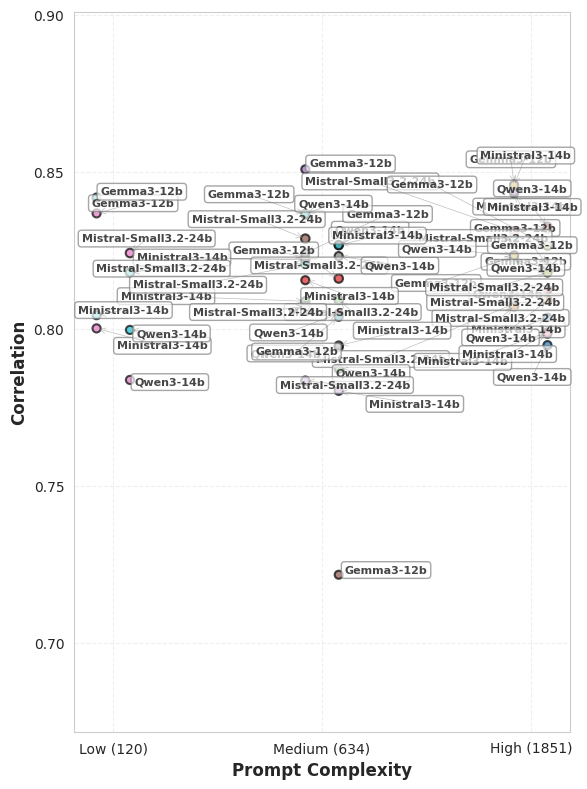

In [27]:
plot_model_metrics_scatter(
    df=df_metrics,
    metric_column="correlation",
    ylabel="Correlation",
    min_threshold=0.1,
    y_padding=0.05,
    figsize=(6, 8),
    shorten_model_names=False,
)

3 [-0.56962404 -0.15428015]
35 [ 0.47615951 -0.15780197]
0 [ 0.52957171 -0.83947259]
5 [ 0.23997651 -0.05188007]


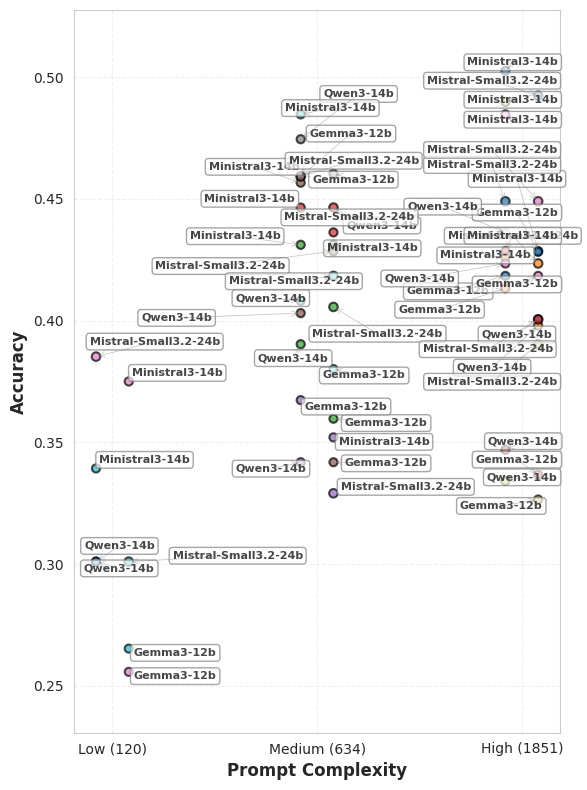

In [28]:
plot_model_metrics_scatter(
    df=df_metrics,
    metric_column="accuracy",
    ylabel="Accuracy",
    min_threshold=0.1,
    y_padding=0.025,
    figsize=(6, 8),
    shorten_model_names=True,
)

### Overall Model Ranking

In [29]:
overall_ranking = (
    df_metrics.groupby("model_name")
    .agg(
        {
            "correlation": "mean",
            "rmse": "mean",
            "accuracy": "mean",
            "throughput": "mean",
            "error_rate": "mean",
        }
    )
    .round(3)
    .sort_values("correlation", ascending=False)
)

print("\nOverall Model Rankings (Average across all prompts):")
print("=" * 80)
print(overall_ranking)


Overall Model Rankings (Average across all prompts):
                      correlation   rmse  accuracy  throughput  error_rate
model_name                                                                
Gemma3-12b                  0.822  1.021     0.374       3.629       0.073
Mistral-Small3.2-24b        0.815  1.084     0.413       6.210       0.000
Ministral3-14b              0.812  1.082     0.434       6.511       0.000
Qwen3-14b                   0.812  1.046     0.385       6.557       0.000


## Tables

In [30]:
df_table = build_prompt_configuration_table(df_metrics)

# Generate LaTeX table
latex_table = df_table.to_latex(
    index=False,
    escape=False,
    caption="Prompt Configuration Evaluation Results",
    label="tab:prompt_configs",
)
print(latex_table)

# Also display as formatted table for quick review
print("\n\nFormatted Table:")
print(df_table.to_string(index=False))

\begin{table}
\caption{Prompt Configuration Evaluation Results}
\label{tab:prompt_configs}
\begin{tabular}{rllllll}
\toprule
\textbf{#} & \textbf{Task Description} & \textbf{Examples} & \textbf{CoT} & \textbf{Best corr. across models} & \textbf{Best RMSE across models} & \textbf{Best Acc. across models} \\
\midrule
1 & Small &  &  & 0.842 & 1.025 & 0.339 \\
2 & Small &  & zero-shot & 0.837 & 0.974 & 0.385 \\
3 & Small & yes &  & \textbf{0.851} & \textbf{0.937} & 0.367 \\
4 & Small & yes & zero-shot & 0.836 & 0.960 & 0.431 \\
5 & Medium &  &  & 0.837 & 1.001 & 0.485 \\
6 & Medium &  & zero-shot & 0.824 & 0.968 & 0.474 \\
7 & Medium & yes &  & 0.829 & 1.010 & 0.457 \\
8 & Medium & yes & zero-shot & 0.823 & 0.975 & 0.459 \\
9 & Medium & yes & few-shot & 0.843 & 0.971 & \textbf{0.503} \\
10 & Large &  &  & 0.846 & 1.000 & 0.490 \\
11 & Large &  & zero-shot & 0.844 & 0.938 & 0.485 \\
12 & Large & yes &  & 0.846 & 0.979 & 0.429 \\
13 & Large & yes & zero-shot & 0.823 & 1.025 & 0.426 \\
14 & 

In [ ]:
summary_table = df_metrics.pivot_table(
    index="model_name",
    columns="prompt",
    values=["correlation", "rmse", "accuracy", "throughput", "error_rate"],
    aggfunc="first",
)

print("Correlation Summary:")
print("=" * 80)
print(summary_table["correlation"].round(3))

print("\n\nRMSE Summary:")
print("=" * 80)
print(summary_table["rmse"].round(3))

print("\n\nAccuracy Summary:")
print("=" * 80)
print(summary_table["accuracy"].round(3))

print("\n\nThroughput Summary (predictions/sec):")
print("=" * 80)
print(summary_table["throughput"].round(3))

print("\n\nError Rate Summary (%):")
print("=" * 80)
print(summary_table["error_rate"].round(1))

Correlation Summary:
prompt                On a scale of 0-5, rate how well this text allows a reader to visualize the scene, objects, or characters described: 0=not visualizable, 1=simple object/person, 2=recognizable place/basic character, 3=basic scene/detailed face, 4=full scene with details, 5=vivid complete scene.\n\n## Examples\nHere are examples demonstrating each rating level:\n\n<example>\n<text_segment>If not, please say so. The alternative is in the hands of the Crown. I am the Crown. The Crown may at any time confiscate property and banish malcontents and disturbers.</text_segment>\n<rating>0</rating>\n</example>\n\n<example>\n<text_segment>By this time the fresh new fool's cap made from yesterday's "Bee" would have been pinned on her head. "Quelle injustice! Quelle injustice!" This last apostrophe in a high, whining nasal voice, always procured Pupasse's elevation on the tall three-legged stool in the corner.</text_segment>\n<rating>1</rating>\n</example>\n\n<example>\n<t

## Multiple Models Comparison

Load metrics and compare multiple LLM models across different prompts.

In [9]:
# Load all metric files
metric_files = sorted(METRICS_DIR.glob("*.json"))
items = load_metric_files(metric_files)

print(f"Loaded {len(items)} metric configurations")

Loaded 14 metric configurations


### Configuration Selection

Select which prompt configuration to evaluate. See available options below.

In [10]:
config_names = [item.get("prompt_id", f"config_{i}") for i, item in enumerate(items)]

print(f"Available configurations ({len(config_names)}):")
for idx, name in enumerate(config_names):
    print(f"  {idx}: {name}")

Available configurations (14):
  0: config_0
  1: config_1
  2: config_2
  3: config_3
  4: config_4
  5: config_5
  6: config_6
  7: config_7
  8: config_8
  9: config_9
  10: config_10
  11: config_11
  12: config_12
  13: config_13


In [11]:
SELECTED_CONFIG_IDX = 1
print(f"Selected configuration: {config_names[SELECTED_CONFIG_IDX]}")

Selected configuration: config_1


### Load and Convert Model Metrics

Convert LLM model metrics to standardized evaluation format.

In [12]:
# Load training and test data
df_train, df_test = load_train_test_data(DATA_DIR)

# Convert metric items to score data format
score_data = to_llm_score_data(items, df_train, df_test)

# Filter for selected configuration
filtered_score_data = [sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX]

print(f"Configuration: Config {SELECTED_CONFIG_IDX}")
print(f"Models in this configuration: {len(filtered_score_data)}")
for sd in filtered_score_data:
    print(f"  - {sd.model_name}")

Configuration: Config 1
Models in this configuration: 4
  - Ministral3-14b
  - Gemma3-12b
  - Qwen3-14b
  - Mistral-Small3.2-24b


In [179]:
# Create core visualization models for selected configuration
multiple_models = []
for sd in filtered_score_data:
    train_outputs = (
        to_int_0_5(sd.train_scores)
        if sd.train_scores is not None and sd.train_scores.size > 0
        else None
    )
    test_outputs = (
        to_int_0_5(sd.test_scores)
        if sd.test_scores is not None and sd.test_scores.size > 0
        else None
    )

    if train_outputs is not None or test_outputs is not None:
        converted = llm_metrics_to_core(
            predictions=train_outputs,
            labels=sd.y_train if train_outputs is not None else None,
            test_predictions=test_outputs,
            test_labels=sd.y_test if test_outputs is not None else None,
            model_name=sd.model_name,
        )
        multiple_models.append(converted)

print(
    f"Loaded {len(multiple_models)} model(s) from configuration {SELECTED_CONFIG_IDX}"
)
for m in multiple_models:
    train_status = "✓" if m.train is not None else "✗"
    test_status = "✓" if m.test is not None else "✗"
    print(f"  - {m.model} [Train: {train_status}, Test: {test_status}]")

Loaded 1 model(s) from configuration 1
  - Mistral-Small3.2-24b [Train: ✓, Test: ✗]


### Per-label metrics and model comparison plots

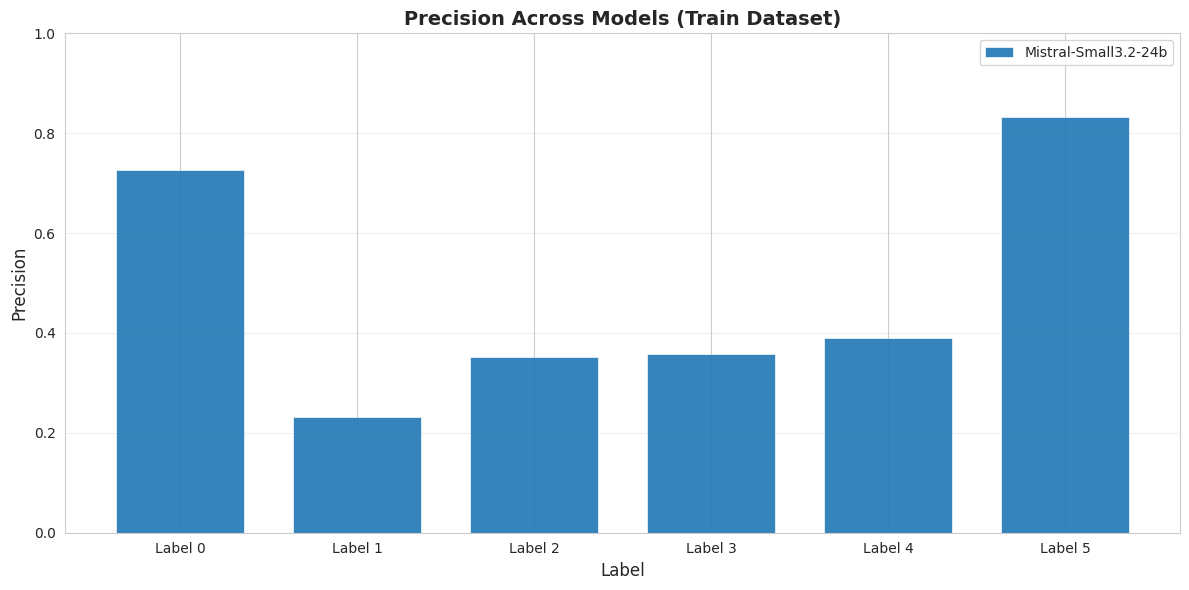

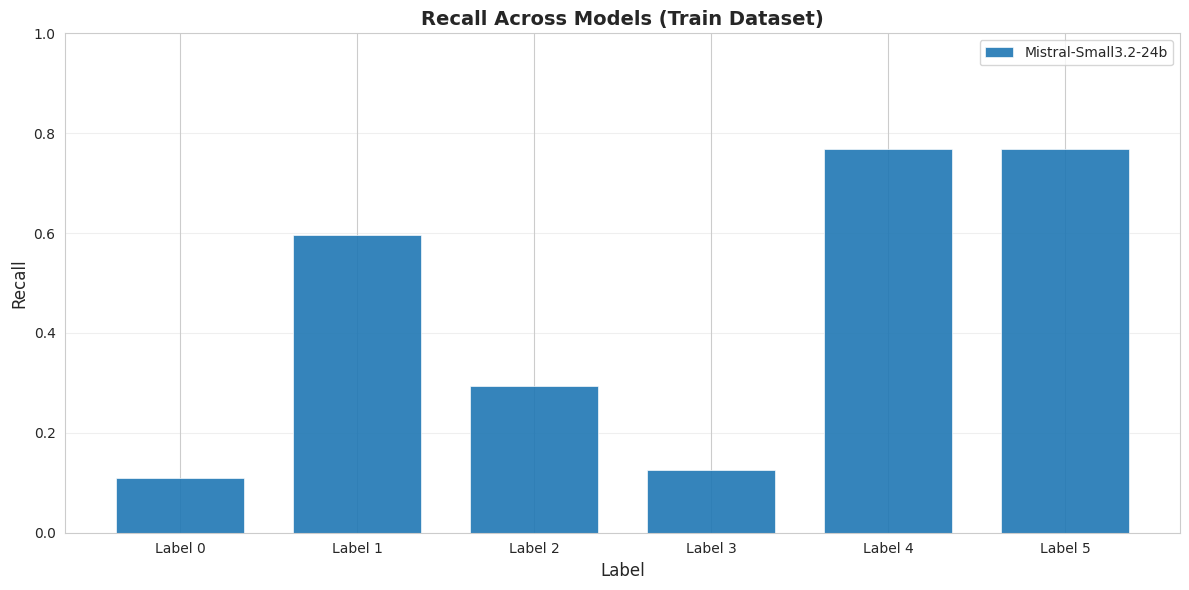

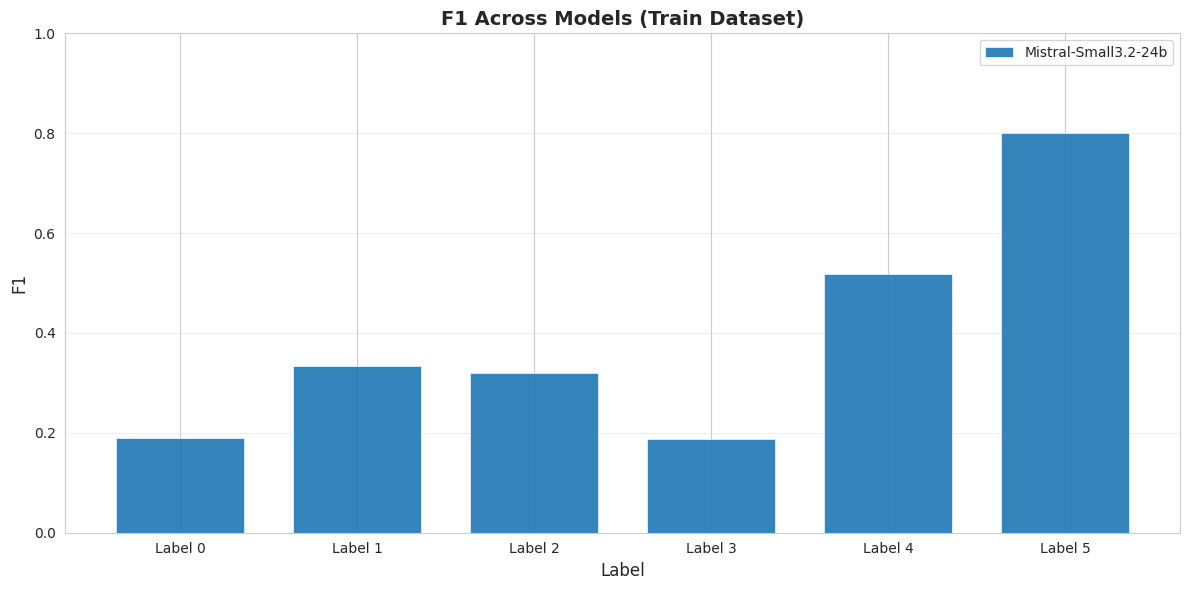

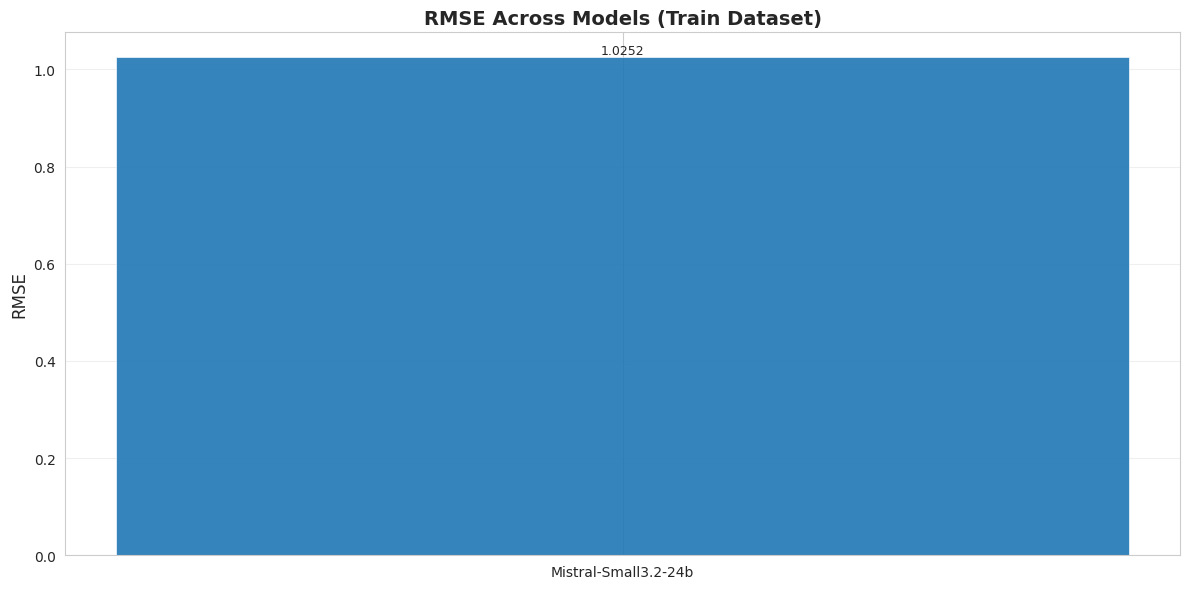

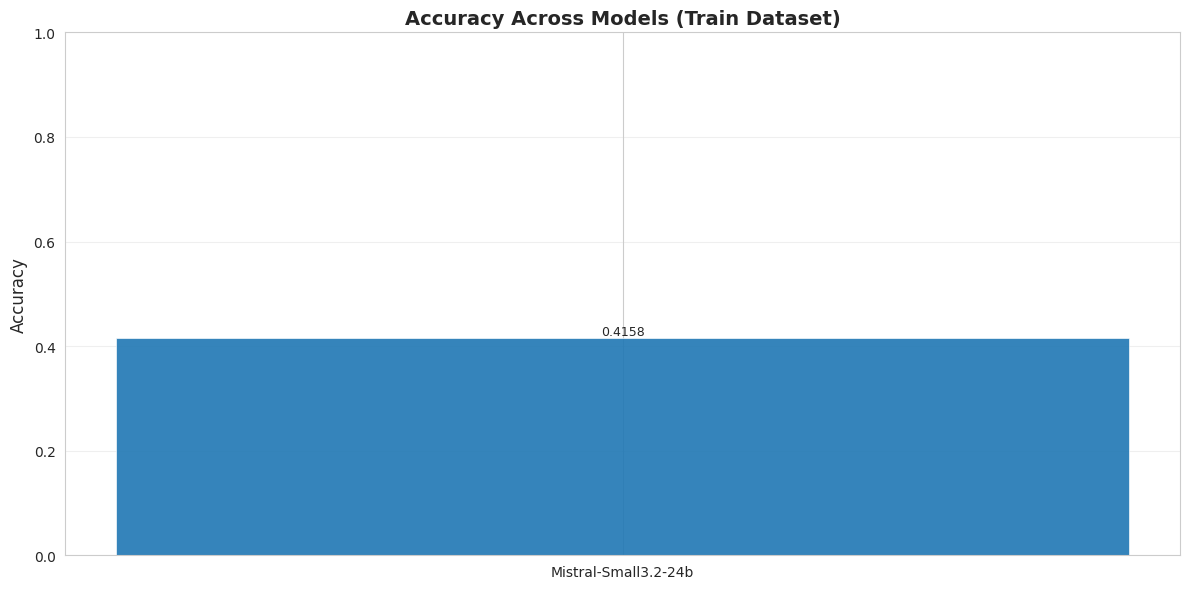

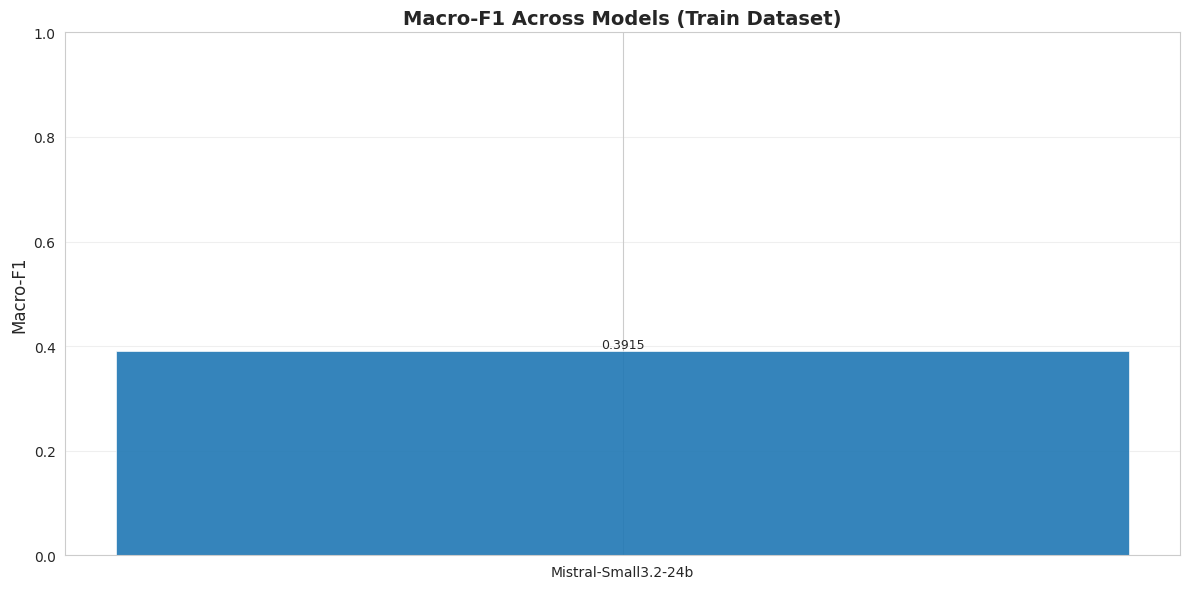

In [180]:
if multiple_models:
    vis_all_models_plots(multiple_models, "train")

### Summary comparison table

In [181]:
if multiple_models:
    model_names = [m.model for m in multiple_models]
    model_groups, show_large_variants = get_llm_model_groups(model_names)
    df_metrics_summary = vis_all_models_tables(
        multiple_models,
        ["RMSE", "Acc"],
        ["Train", "Test"],
        model_groups,
        show_large_variants,
    )
    latex_table = format_metrics_for_latex(df_metrics_summary)
    print(latex_table)

,Model,Train RMSE,Test RMSE,Train Acc,Test Acc
0,Mistral-Small3.2-24b,1.0252,,0.4158,


\begin{tabular}{rrrrr}
\toprule
\textbf{Model} & \textbf{Train RMSE} & \textbf{Test RMSE} & \textbf{Train Acc} & \textbf{Test Acc} \\
\midrule
Mistral-Small3.2-24b & \textbf{1.0252} &  & \textbf{0.4158} &  \\
\bottomrule
\end{tabular}



/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:921: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{1.0252}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  
/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:921: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.4158}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  
